In [1]:
import pandas as pd
from rdkit import Chem
from rdkit import Chem
from copy import deepcopy

def calculate_chemical_properties(dictionary_list):
    updated_list = deepcopy(dictionary_list)  # Create a deep copy of the original list
    for entry in updated_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']

        # Process for carbon difference calculation
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)

        if reactant_mol is not None and product_mol is not None:
            num_carbon_reactants = reactant_mol.GetNumAtoms(6)
            num_carbon_products = product_mol.GetNumAtoms(6)
            delta = abs(num_carbon_reactants - num_carbon_products)
            entry['carbon_difference'] = delta
        else:
            entry['carbon_difference'] = "Invalid SMILES"

        # Process for fragment count calculation
        reactant_fragment_count = len(reactant_smiles.split('.'))
        product_fragment_count = len(product_smiles.split('.'))
        total_fragment_count = reactant_fragment_count + product_fragment_count
        entry['fragment_count'] = total_fragment_count

    return updated_list


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False, show_values=False):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        group_data = group_data[group_data['Accuracy'] > 0]  # Filter out groups with zero accuracy

        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    cmap = plt.get_cmap('flare', 256)

    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'Bond Changes')

    # Determine the global maximum size for same color scale
    if same_color_scale:
        max_size = max(accuracy_carbon['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max())
        norm = plt.Normalize(vmin=0, vmax=max_size)
    else:
        norm = None

    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), gridspec_kw={'hspace': 0.3})

    def plot_data(data, x, y, lower, upper, size, subplot_index, xlabel, ecolor, norm, show_values):
        ax = axes[subplot_index]
        local_norm = norm if same_color_scale else plt.Normalize(vmin=0, vmax=data[size].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=local_norm)
        sm.set_array([])

        colors = [mcolors.to_rgba(cmap(local_norm(s))) for s in data[size]]

        if chart_type == 'line':
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax, palette=colors)
            if error_bar:
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
        elif chart_type == 'bar':
            barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)
            if error_bar:
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

            # Annotate bar values if show_values is True
            if show_values:
                for bar in barplot.patches:
                    ax.annotate(format(bar.get_height(), '.2f'),
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                ha='center', va='bottom',
                                xytext=(0, 5), textcoords='offset points')

        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        ax.set_facecolor('white')
        cbar = plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        ax.xaxis.set_label_position('bottom')
        ax.xaxis.tick_top()
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.text(-0.1, 1.1, chr(65 + subplot_index), transform=ax.transAxes, size=20, weight='bold')

    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 'Number of Carbons Difference', error_bar_color, norm, show_values)
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 1, 'Number of Fragments', error_bar_color, norm, show_values)
    plot_data(accuracy_bondchanges, 'Bond Changes', 'Accuracy', 'lower', 'upper', 'size', 2, 'Number of Bond Changes', error_bar_color, norm, show_values)

    plt.tight_layout(pad=4.0)
    plt.show()

# Example usage (assuming 'data3' is a suitable DataFrame)
# visualize_accuracy(data3, error_bar=True, chart_type='bar', error_bar_color='gray', same_color_scale=True, show_values=True)


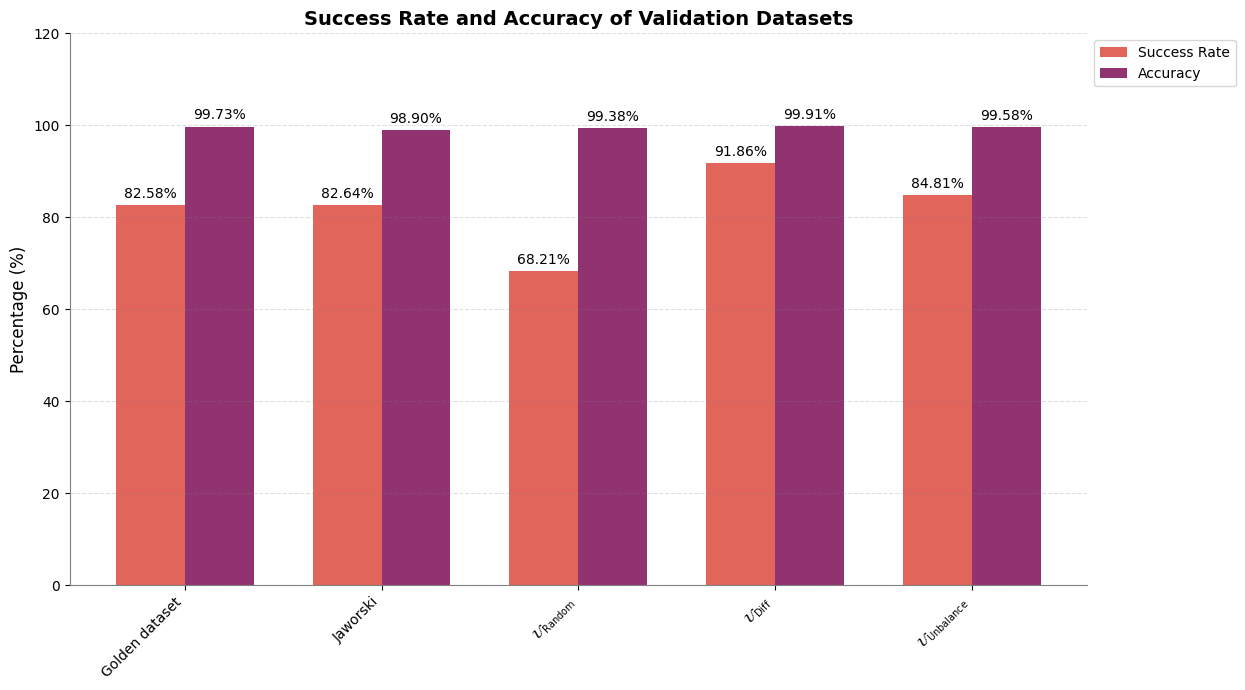

In [6]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = [82.58, 82.64, 68.21, 91.86, 84.81]
accuracy = [99.73, 98.90, 99.38, 99.91, 99.58]

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Using the "flare" colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)  # A specific color from the "flare" colormap for Success Rate
color_for_accuracy = cmap(0.7)  # A different specific color from the "flare" colormap for Accuracy

bars1 = ax.bar(index - bar_width/2, success_rate, bar_width, label='Success Rate', color=color_for_success_rate)
bars2 = ax.bar(index + bar_width/2, accuracy, bar_width, label='Accuracy', color=color_for_accuracy)

#plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 120)

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


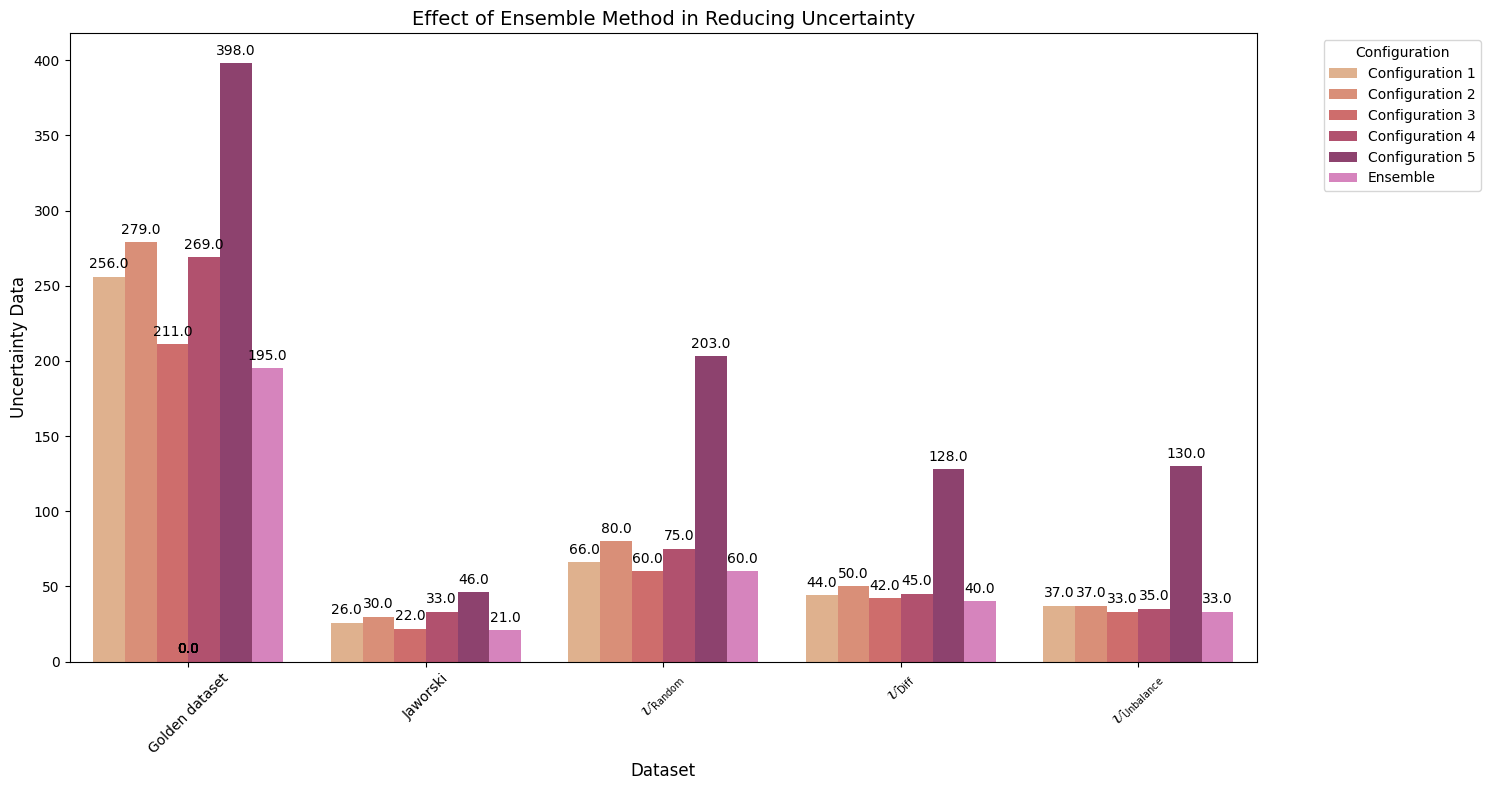

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Plot
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='Dataset', y='Value', hue='Configuration', data=df, palette=palette)

# Customizing the plot
plt.title('Effect of Ensemble Method in Reducing Uncertainty', fontsize=14)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar with the value
for p in bar_plot.patches:
    text = format(p.get_height(), '.1f')
    bar_plot.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()


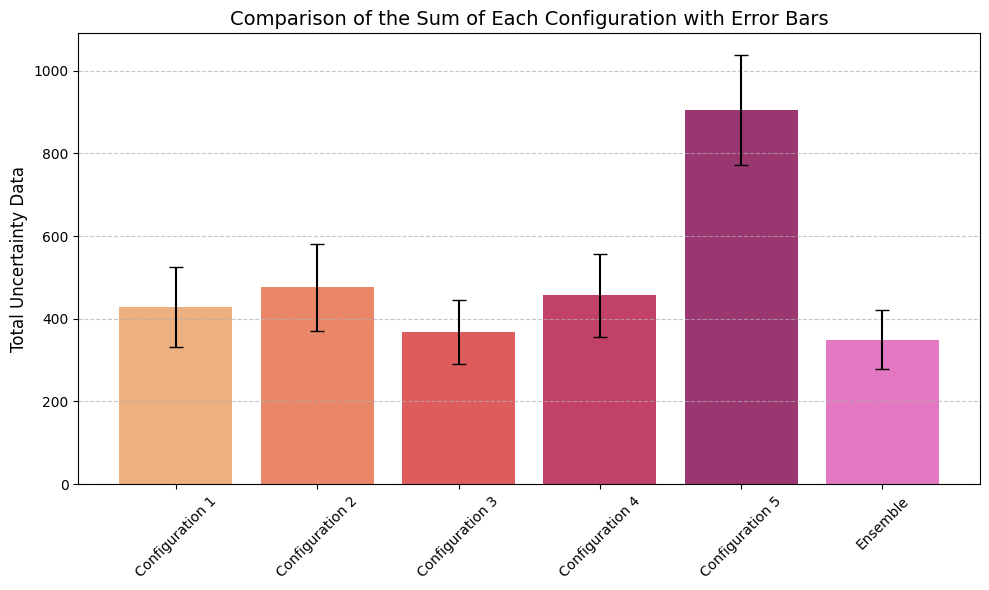

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars
plt.figure(figsize=(10, 6))
plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


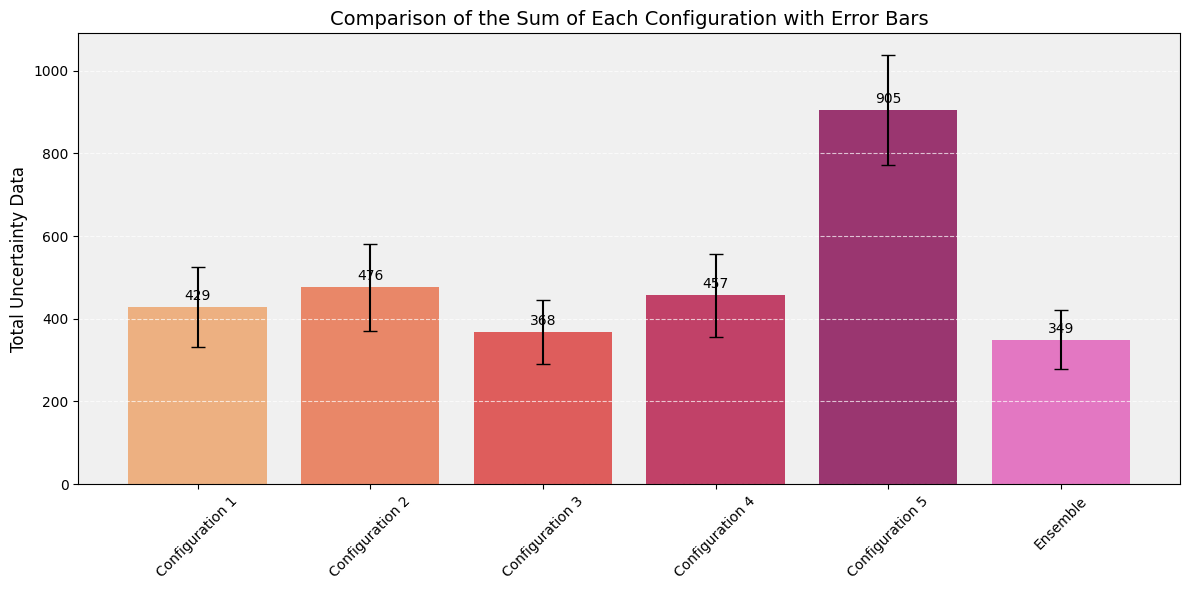

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
